In [1]:
import os
import sys
import glob
import operator as op
import itertools as it
from functools import reduce, partial
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)
%matplotlib inline

from sympy import symbols, hessian, Function, N

# Algorithms for Optimization and Root Finding for Multivariate Problems

**Note**: much of the following notes are taken from Nodecal, J., and S. J. Wright. "Numerical optimization." (2006). It is available online via the library.

## Convexity

A subset $A\subset \mathbb{R}^n$ is *convex* if for any two points $x,y\in A$, the line segment:

$$tx + (1-t)y \;\;\;\;\;\; t\in [0,1]$$
is also in $A$

A function $f:\mathbb{R}^n \rightarrow \mathbb{R}$ is *convex* if its domain $D$ is a convex set and for any two points $x,y\in D$, the graph of $f$ (a subset of $\mathbb{R}^{n+1})$ lies below the line:

$$tf(x) + (1-t)f(y)\;\;\;\;\;t\in [0,1]$$

i.e. 
$$f(tx+(1-t)y) \leq tf(x) + (1-t)f(y)\;\;\;\;\;t\in [0,1]$$

#### Convexity guarantees that if an optimizer converges, it converges to the global minimum.

Luckily, we often encounter convex problems in statistics.

## Line Search Methods

There are essentially two classes of multivariate optimization methods. We'll cover line search methods, but refer the reader to Nodecal and Wright for discussion of 'trust region methods'. We should note that all of these methods require that we are 'close' to the minimum (maximum) we are seeking, and that 'noisy' functions or ill-behaved functions are beyond our scope.

A line search method is exactly as it sounds - we search on a line (in $n$ dimensional space) and try to find a minimum.  We start with an initial point, and use an iterative method:

$$x_{k+1} = x_k + \alpha_k p_k$$

where $\alpha_k$ is the *step size* and $p_k$ is the search direction. These are the critical choices that change the behavior of the search. 

#### Step Size

Ideally, (given a choice of direction, $p_k$) we would want to minimize:

$$\varphi(\alpha) = f(x_k + \alpha p_k)$$

with respect to $\alpha$. This is usually computationally intensive, so in practice, a sequence of $\alpha$ candidates are generated, and then the 'best' is chosen according to some 'conditions'. We won't be going into detail regarding these. The important thing to know is that they ensure that $f$ decreases sufficiently, according to some conditions. Interested students should see Nodecal.

## Steepest Descent

In steepest descent, one chooses $p_k=\nabla f_k = \nabla f(x_k)$. It is so named, because the gradient points in the direction of steepest ascent, thus, $-\nabla f_k$ will point in the direction of steepest descent. We'll consider this method in its ideal case, that of a quadratic:

$$f(x) = \frac12 x^TQx - b^Tx$$

where $Q$ is positive-definite and symmetric. Note that:

$$\nabla f = Qx -b$$

so the minimum occurs at $x$ such that

$$Qx= b$$

Clearly, we can solve this easily, but let's walk through the algorithm and first find the (ideal) step length:

$$f(x_k - \alpha \nabla f_k) = \frac12\left(x_k - \alpha \nabla f_k\right)^TQ\left(x_k - \alpha \nabla f_k\right) - b^T \left(x_k - \alpha \nabla f_k\right) $$

If we differentiate this with respect to $\alpha$ and find the zero, we obtain:

$$\alpha_k = \frac{\nabla f_k^T\nabla f_k}{\nabla f_k^TQ\nabla f_k}$$

Thus, 

$$x_{k+1} = x_k - \frac{\nabla f_k^T\nabla f_k}{\nabla f_k^TQ\nabla f_k} \nabla f_k$$

But we know that $\nabla f_k = Qx_k -b$, so we have a closed form solution for $x_{k+1}$. This allows us to compute an error bound. Again, details can be found in the text, but here is the result:

$$||x_{k+1} - x^*||_Q^2 \leq \left(\frac{\lambda_n - \lambda_1}{\lambda_n+\lambda_1}\right)^2 ||x_{k} - x^*||_Q^2$$

where $0<\lambda_1\leq ... \leq \lambda_n$ and $x^*$ denotes the minimizer.

Now, if $\lambda_1=...=\lambda_n = \lambda$, then $Q=\lambda I$, the algorithm converges in one step. Geometrically, the contours are ellipsoids, the value of $\frac{\lambda_n}{\lambda_1}$ elongates the axes and causes the steps to 'zig-zag'. Because of this, convergence slows as $\frac{\lambda_n}{\lambda_1}$ increases.


## Newton's Method

Newton's method is another line-search, and here 

$$p_k = -H^{-1}\nabla f_k$$

Note that if the Hessian is not positive definite, this may not always be a descent direction.

In the neighborhood of a local minimum, the Hessian *will* be positive definite. Now, if $x_0$ is 'close enough' to the minimizer $x^*$, the step size $\alpha_k =1$ gives quadratic convergence. 

The advantage of multiplying the gradient by the inverse of the Hessian is that the gradient is corrected for curvature, and the new direction points toward the minimum.

In [2]:

#def Quad(x):
#    return (x[1:])*np.sin(x[:-1])**2.0)

#def DQuad(x,y):
#    return (np.array([np.cos(x)*np.sin(y)**2.0,2.0*np.sin(x)*np.cos(y)**2.0]))

def Quad(x):
    return ((x[1:])**2.0 + 5*(x[:-1])**2.0)

def DQuad(x,y):
    return (np.array([2.0*x,10.0*y]))

In [3]:
x = np.linspace(-20,20, 100)
y = np.linspace(-20,20, 100)
X, Y = np.meshgrid(x, y)
Z = Quad(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
Hinv=-np.array([[0.5,0],[0,0.1]])

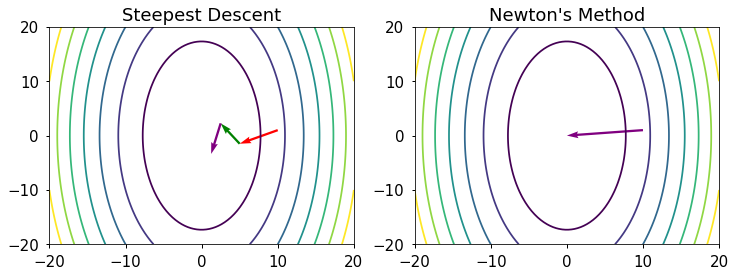

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(121)

plt.contour(X,Y,Z);
plt.title("Steepest Descent");
step=-0.25
X0 = 10.0
Y0 = 1.0

Ngrad=Hinv.dot(DQuad(X0,Y0))

sgrad = step*DQuad(X0,Y0)
plt.quiver(X0,Y0,sgrad[0],sgrad[1],color='red',angles='xy',scale_units='xy',scale=1);
X1 = X0 + sgrad[0]
Y1 = Y0 + sgrad[1]
sgrad = step*DQuad(X1,Y1)
plt.quiver(X1,Y1,sgrad[0],sgrad[1],color='green',angles='xy',scale_units='xy',scale=1);
X2 = X1 + sgrad[0]
Y2 = Y1 + sgrad[1]
sgrad = step*DQuad(X2,Y2)
plt.quiver(X2,Y2,sgrad[0],sgrad[1],color='purple',angles='xy',scale_units='xy',scale=1);


plt.subplot(122)
plt.contour(X,Y,Z);
plt.title("Newton's Method")
plt.quiver(X0,Y0,Ngrad[0],Ngrad[1],color='purple',angles='xy',scale_units='xy',scale=1);

#Compute Hessian and plot again.


## Coordinate Descent

Another method is called 'coordinate' descent, and it involves searching along coordinate directions (cyclically), i.e.:

$$p_{mk} = e_{k} \;\;\;\;\;\; k=1,...,n$$

where $m$ is the number of steps.

The main advantage is that $\nabla f$ is not required. It can behave reasonably well, if coordinates are not tightly coupled. 

### Newton CG Algorithm

Features:

* Minimizes a 'true' quadratic on $\mathbb{R}^n$ in $n$ steps
* Does NOT require storage or inversion of an $n \times n$ matrix.

We begin with $:\mathbb{R}^n\rightarrow \mathbb{R}$.  Take a quadratic approximation to $f$:

$$f(x) \approx \frac12 x^T H x + b^Tx + c$$

Note that in the neighborhood of a minimum, $H$ will be positive-definite (and symmetric). (If we are maximizing, just consider $-H$).

This reduces the optimization problem to finding the zeros of 

$$Hx = -b$$

This is a linear problem, which is nice.  The dimension $n$ may be very large - which is not so nice.

#### General Inner Product

Recall the axiomatic definition of an inner product $<,>_A$:

* For any two vectors $v,w$ we have
$$<v,w>_A = <w,v>_A$$
* For any vector $v$
$$<v,v>_A \;\geq 0$$
   with equality $\iff$ $v=0$.
* For $c\in\mathbb{R}$ and $u,v,w\in\mathbb{R}^n$, we have
$$<cv+w,u> = c<v,u> + <w,u>$$

These properties are known as symmetric, positive definite and bilinear, respectively.

Fact: If we denote the standard inner product on $\mathbb{R}^n$ as $<,>$ (this is the 'dot product'), any symmetric, positive definite $n\times n$ matrix $A$ defines an inner product on $\mathbb{R}^n$ via:

$$<v,w>_A \; = <v,Aw> = v^TAw$$

Just as with the standard inner product, general inner products define for us a notion of 'orthogonality'. Recall that with respect to the standard product, 2 vectors are orthogonal if their product vanishes. The same applies to $<,>_A$:

$$<v,w>_A = 0 $$

means that $v$ and $w$ are orthogonal under the inner product induced by $A$.  Equivalently, if $v,w$ are orthogonal under $A$, we have:

$$v^TAw = 0$$

This is also called *conjugate* (thus the name of the method).

#### Conjugate Vectors

Suppose we have a set of $n$ vectors $p_1,...,p_n$ that are mutually conjugate.  These vectors form a basis of $\mathbb{R}^n$.  Getting back to the problem at hand, this means that our solution vector $x$ to the linear problem may be written as follows:

$$x = \sum\limits_{i=1}^n \alpha_i p_i$$

So, finding $x$ reduces to finding a conjugate basis and the coefficients for $x$ in that basis.

If we let $A=H$,note that:

$${p}_k^{T} {-b}={p}_k^{T} {A}{x}$$

and because $x = \sum\limits_{i=1}^n \alpha_i p_i$, we have:
$$p^TAx = \sum\limits_{i=1}^n \alpha_i p^TA p_i$$

we can solve for $\alpha_k$:

$$\alpha_k = \frac{{p}_k^{T}{(-b)}}{{p}_k^{T} {A}{p}_k} = -\frac{\langle {p}_k, {b}\rangle}{\,\,\,\langle {p}_k,  {p}_k\rangle_{A}} = -\frac{\langle{p}_k, {b}\rangle}{\,\,\,\|{p}_k\|_{A}^2}.$$


Now, all we need are the $p_k$'s.

A nice initial guess would be the gradient at some initial point $x_1$.  So, we set $p_1 = \nabla f(x_1)$. Then set:

$$x_2 = x_1 + \alpha_1p_1$$

This should look familiar.  In fact, it is gradient descent.  For $p_2$, we want $p_1$ and $p_2$ to be conjugate (under $A$).  That just means orthogonal under the inner product induced by $A$.  We set 

$$p_2 = \nabla f(x_2) - \frac{p_1^TA\nabla f(x_2)}{{p}_1^{T}{A}{p}_1} {p}_1$$

I.e. We take the gradient at $x_1$ and subtract its projection onto $p_1$.  This is the same as Gram-Schmidt orthogonalization.

The $k^{th}$ conjugate vector is:

$$p_{k} = \nabla f(x_k) - \sum\limits_{i=1}^{k-1}\frac{p_i^T A \nabla f(x_k)}{p_i^TAp_i} p_i$$

The 'trick' is that in general, we do not need all $n$ conjugate vectors. In fact, it turns out that $\nabla f(x_k) = b-Ax_k$ is conjugate to all the $p_i$ for $i=1,...,k-2$. Therefore, we need only the last term in the sum.

Convergence rate is dependent on sparsity and condition number of $A$.  Worst case is $n^2$.

### BFGS - Broyden–Fletcher–Goldfarb–Shanno

BFGS is a 'quasi' Newton method of optimization.  Such methods are variants of the Newton method, where the Hessian $H$ is replaced by some approximation.  We we wish to solve the equation:

$$B_k{p}_k = -\nabla f({x}_k)$$

for $p_k$. This gives our search direction, and the next candidate point is given by:

$$x_{k+1} = x_k + \alpha_k p_k$$.

where $\alpha_k$ is a step size.

At each step, we require that the new approximate $H$ meets the secant condition:

$$B_{k+1}(x_{k+1}-x_k) = \nabla f(x_{k+1}) -\nabla f(x_k)$$

There is a unique, rank one update that satisfies the above:

$$B_{k+1} = B_k + c_k v_kv_k^T$$

where

$$ c_k = -\frac{1}{\left(B_k(x_{k+1}-x_k) - (\nabla f(x_{k+1})-\nabla f(x_k)\right)^T (x_{k+1}-x_k) }$$ 

and

$$v_k = B_k(x_{k+1}-x_k) - (\nabla f(x_{k+1})-\nabla f(x_k))$$

Note that the update does NOT preserve positive definiteness if $c_k<0$.  In this case, there are several options for the rank one correction, but we will not address them here.  Instead, we will describe the BFGS method, which almost always guarantees a positive-definite correction.  Specifically:

$$B_{k+1} = B_k + b_k g_k g_k^T + c_k B_k d_k d_k^TB_k$$ 

where we have introduced the shorthand:

$$g_k = \nabla f(x_{k+1}) - \nabla f(x_k) \;\;\;\;\;\;\;\ \mathrm{ and }\;\;\;\;\;\;\; d_k = x_{k+1} - x_k$$

If we set:

$$b_k = \frac{1}{g_k^Td_k} \;\;\;\;\; \mathrm{ and } \;\;\;\;\; c_k = \frac{1}{d_k^TB_kd_k}$$

we satisfy the secant condition.

### Nelder-Mead Simplex

While Newton's method is considered a 'second order method' (requires the second derivative), and quasi-Newton methods are first order (require only first derivatives), Nelder-Mead is a zero-order method.  I.e. NM requires only the function itself - no derivatives.

For $f:\mathbb{R}^n\rightarrow \mathbb{R}$, the algorithm computes the values of the function on a simplex of dimension $n$, constructed from $n+1$ vertices.  For a univariate function, the simplex is a line segment.  In two dimensions, the simplex is a triangle, in 3D, a tetrahedral solid, and so on.

The algorithm begins with $n+1$ starting points and then the follwing steps are repeated until convergence:

* Compute the function at each of the points
* Sort the function values so that 
$$f(x_1)\leq ...\leq f(x_{n+1})$$
* Compute the centroid $x_c$ of the n-dimensional region defined by $x_1,...,x_n$
* Reflect $x_{n+1}$ about the centroid to get $x_r$
$$x_r = x_c + \alpha (x_c - x_{n+1})$$
* Create a new simplex according to the following rules:
    - If $f(x_1)\leq f(x_r) < f(x_n)$, replace $x_{n+1}$ with $x_r$
    - If $f(x_r)<f(x_1)$, expand the simplex through $x_r$:
    $$x_e = x_c + \gamma (x_c - x_{n+1})$$
      If $f(x_e)<f(x_r)$, replace $x_{n+1}$ with $x_e$, otherwise, replace $x_{n+1}$ with $x_r$
    - If $f({x}_{r}) \geq f({x}_{n})$, compute $x_p = x_c + \rho(x_c - x_{n+1})$.  If $f({x}_{p}) < f({x}_{n+1})$, replace $x_{n+1}$ with $x_p$
    - If all else fails, replace *all* points except $x_1$ according to
    $$x_i = {x}_{1} + \sigma({x}_{i} - {x}_{1})$$
    
The default values of $\alpha, \gamma,\rho$ and $\sigma$ in scipy are not listed in the documentation, nor are they inputs to the function.

### Powell's Method

Powell's method is another derivative-free optimization method that is similar to conjugate-gradient.  The algorithm steps are as follows:

Begin with a point $p_0$ (an initial guess) and a set of vectors $\xi_1,...,\xi_n$, initially the standard basis of $\mathbb{R}^n$.  

- Compute for $i=1,...,n$, find $\lambda_i$ that minimizes $f(p_{i-1} +\lambda_i \xi_i)$ and set $p_i = p_{i-1} + \lambda_i\xi_i$
- For $i=1,...,n-1$, replace $\xi_{i}$ with $\xi_{i+1}$ and then replace $\xi_n$ with $p_n - p_0$
- Choose $\lambda$ so that $f(p_0 + \lambda(p_n-p_0)$ is minimum and replace $p_0$ with $p_0 + \lambda(p_n-p_0)$

Essentially, the algorithm performs line searches and tries to find fruitful directions to search.

## Solvers

### Levenberg-Marquardt (Damped Least Squares)

Recall the least squares problem:
    
Given a set of data points $(x_i, y_i)$ where $x_i$'s are independent variables (in $\mathbb{R}^n$ and the $y_i$'s are response variables (in $\mathbb{R}$), find the parameter values of $\beta$ for the model $f(x;\beta)$ so that

$$S(\beta) = \sum\limits_{i=1}^m \left(y_i - f(x_i;\beta)\right)^2$$
is minimized.

If we were to use Newton's method, our update step would look like:

$$\beta_{k+1} = \beta_k - H^{-1}\nabla S(\beta_k)$$

Gradient descent, on the other hand, would yield:

$$\beta_{k+1} = \beta_k - \gamma\nabla S(\beta_k)$$

Levenberg-Marquardt adaptively switches between Newton's method and gradient descent.  

$$\beta_{k+1} = \beta_k - (H + \lambda I)^{-1}\nabla S(\beta_k)$$

When $\lambda$ is small, the update is essentially Newton-Gauss, while for $\lambda$ large, the update is gradient descent.

### Newton-Krylov

The notion of a Krylov space comes from the Cayley-Hamilton theorem (CH).  CH states that a matrix $A$ satisfies its characteristic polynomial.  A direct corollary is that $A^{-1}$ may be written as a linear combination of powers of the matrix (where the highest power is $n-1$).  

The Krylov space of order $r$ generated by an $n\times n$ matrix $A$ and an $n$-dimensional vector $b$ is given by:

$$\mathcal{K}_r(A,b) = \operatorname{span} \, \{ b, Ab, A^2b, \ldots, A^{r-1}b \}$$

These are actually the subspaces spanned by the conjugate vectors we mentioned in Newton-CG, so, technically speaking, Newton-CG is a Krylov method.

Now, the scipy.optimize newton-krylov solver is what is known as a 'Jacobian Free Newton Krylov'.  It is a very efficient algorithm for solving *large* $n\times n$ non-linear systems.  We won't go into detail of the algorithm's steps, as this is really more applicable to problems in physics and non-linear dynamics.

## GLM Estimation and IRLS

Recall generalized linear models are models with the following components:

* A linear predictor $\eta = X\beta$
* A response variable with distribution in the exponential family
* An invertible 'link' function $g$ such that
$$E(Y) = \mu = g^{-1}(\eta)$$

We may write the log-likelihood:

$$\ell(\eta) = \sum\limits_{i=1}^m (y_i \log(\eta_i) + (\eta_i - y_i)\log(1-\eta_i) $$

where $\eta_i = \eta(x_i,\beta)$.

Differentiating, we obtain:

$$\frac{\partial L}{\partial \beta} = \frac{\partial \eta}{\partial \beta}^T\frac{\partial L}{\partial \eta} = 0$$

Written slightly differently than we have in the previous sections, the Newton update to find $\beta$ would be:

$$-\frac{\partial^2 L}{\partial \beta \beta^T} \left(\beta_{k+1} -\beta_k\right) = \frac{\partial \eta}{\partial \beta}^T\frac{\partial L}{\partial \eta}$$

Now, if we compute:

$$-\frac{\partial^2 L}{\partial \beta \beta^T} = \sum \frac{\partial L}{\partial \eta_i}\frac{\partial^2 \eta_i}{\partial \beta \beta^T} - \frac{\partial \eta}{\partial \beta}^T \frac{\partial^2 L}{\partial \eta \eta^T}  \frac{\partial \eta}{\partial \beta}$$

Taking expected values on the right hand side and noting:

$$E\left(\frac{\partial L}{\partial \eta_i} \right) = 0$$

and 

$$E\left(-\frac{\partial^2 L}{\partial \eta \eta^T} \right) = E\left(\frac{\partial L}{\partial \eta}\frac{\partial L}{\partial \eta}^T\right) \equiv A$$

So if we replace the Hessian in Newton's method with its expected value, we obtain:

$$\frac{\partial \eta}{\partial \beta}^TA\frac{\partial \eta}{\partial \beta}\left(\beta_{k+1} -\beta_k\right) = \frac{\partial \eta}{\partial \beta}^T\frac{\partial L}{\partial \eta} $$

Now, these actually have the form of the normal equations for a weighted least squares problem.  

$$\min_{\beta_{k+1}}\left(A^{-1}\frac{\partial L}{\partial \eta} + \frac{\partial \eta}{\partial \beta}\left(\beta_{k+1} -\beta_k\right)\right)^T A \left(A^{-1}\frac{\partial L}{\partial \eta} + \frac{\partial \eta}{\partial \beta}\left(\beta_{k+1} -\beta_k\right)\right)$$

$A$ is a weight matrix, and changes with iteration - thus this technique is *iteratively reweighted least squares*.

### Constrained Optimization and Lagrange Multipliers

Often, we want to optimize a function subject to a constraint or multiple constraints.  The most common analytical technique for this is called 'Lagrange multipliers'.  The theory is based on the following:

If we wish to optimize a function $f(x,y)$ subject to the constraint $g(x,y)=c$, we are really looking for points at which the gradient of $f$ and the gradient of $g$ are in the same direction.  This amounts to:

$$\nabla_{(x,y)}f = \lambda \nabla_{(x,y)}g$$

(often, this is written with a (-) sign in front of $\lambda$). The 2-d problem above defines two equations in three unknowns.  The original constraint, $g(x,y)=c$ yields a third equation.  Additional constraints are handled by finding:

$$\nabla_{(x,y)}f = \lambda_1 \nabla_{(x,y)}g_1 + ... + \lambda_k \nabla_{(x,y)}g_k$$



![Lagrange Multipliers](./Lagrange_multiplier.png)




The generalization to functions on $\mathbb{R}^n$ is also trivial:

$$\nabla_{x}f = \lambda \nabla_{x}g$$